In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

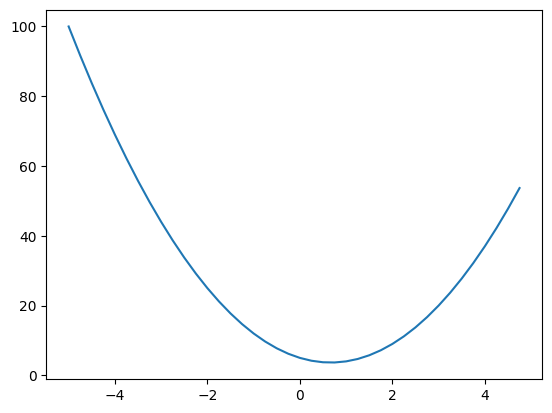

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Demonstrate how to find the derivatives (rate of change) of the function
h = 0.0000001
x = 3.0
f(x + h)  # 20.00000140000003 

# the function goes up when with the derivative (rate of change) for h is:
(f(x + h) - f(x))/h # 14.000000305713911

# for a negative value such as -3.0, and the h is positive, the slope goes down
h = 0.0000001
x = -3.0
f(x + h) # 43.99999780000003
(f(x + h) - f(x)) / h

-21.999999688659955

In [6]:
# a more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1) # 4
print('d2', d2) # 3.999699999999999
print('slope', (d2 - d1)/h) # -3.000000000010772 --> b

a = 2.0
b = -3.0
c = 10.0

b += h
d3 = a*b + c
print('d3', d3) # d3 4.0002 
print('slope d3', (d3 - d1)/h) # 2.0000000000042206 --> a

a = 2.0
b = -3.0
c = 10.0

c += h
d4 = a*b + c
print('d4', d4) # 4.0001
print('slope d4', (d4 - d1)/h) # 0.9999999999976694 



d1 4.0
d2 3.999699999999999
slope -3.000000000010772
d3 4.0002
slope d3 2.0000000000042206
d4 4.0001
slope d4 0.9999999999976694


In [8]:
class Value: 
    """
    Represents a value in a computational graph, typically used for building an autograd system.
    It stores the value of a computation and tracks its relationship with other values for gradient computation (backpropagation).
    """
    def __init__(self, data, _children=(), _op='', label=''):
        # A constructor for the class to create object 
        # It's called automatically when creating a new instance of the class
        # self is similar to this in Java, but it has to be specified in Python and must come as the first parameter
        # :_children=(): an optional parameter with a default value of an empty tuple ().
        # _ before _children and _op is a convention in Python indicating that these attributes are intended to be private to the class.
        # It suggests that they are internal details, not meant to be accessed directly outside the class, though it does not prevent access.
        self.data = data
        self.grad = 0.0              # gradient = 0 meaning it does not affect the loss function value as default
                                     # it represent the derivatives of L (loss function) in regards to each node/weight of the model in backpropagation
        self._prev = set(_children)  # keep track of the "previous" Value objects involved in the operation
                                     # It's a set of other Value objects that were used in the current opeartion, enabling backtracking during gradient computation
        self._op = _op               # Stores the operation performed to create the current Value object.
                                     # This helps in determining how to compute derivatives during backpropagation or other opeartions.
        self.label = label
        
    def __repr__(self):
        # The representation method defining how the object is represented as a string when printed or logged
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
L
# a.__mul__(b).__add__(c)

Value(data=-8.0)

In [9]:
from graphviz import Digraph

def trace(root):
    # Initialize two sets to store nodes and edges of the graph.
    # `nodes` store all the nodes encountered.
    # `edges` store all the edges between nodes as tuples (parent, child).
    nodes, edges = set(), set()


    # define a helper function `build` that will recursively traverse the graph
    # starting from the node `v' and gather all the nodes and edges.
    def build(v):
        # If this node `v` has not been visited yet, process it.
        if v not in nodes:
            # Add the node `v` to the set of nodes (use set to avoid duplicates)
            nodes.add(v)

            # Iterate through each of `v`'s previous nodes (parents)
            # In the context of the graph. `v._prev` represents the nodes that point to `v`
            for child in v._prev:
                # For each child (parent -> child), add an edge (parent, child)
                edges.add((child, v)) # Add an edge from `child` to `v` (parent -> child)

                # Recursively call `build` for each child node to continue travesing.
                build(child)

    # Start the graph-building process by calling `build` on the root node.
    build(root)
    
    return nodes, edges

def draw_dot(root):
    # Create a Digraph objec to represent the graph as a directed graph in SVG output.
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    
    for n in nodes:
        # Generate a unique identifier (uid) for the node based on its memory address.
        # `id(n)` returns the memory address of the node object, which is used as a unique Id.
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        # The `shape='record'` option specifies that the node should be rectangular.
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        
        if n._op: 
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

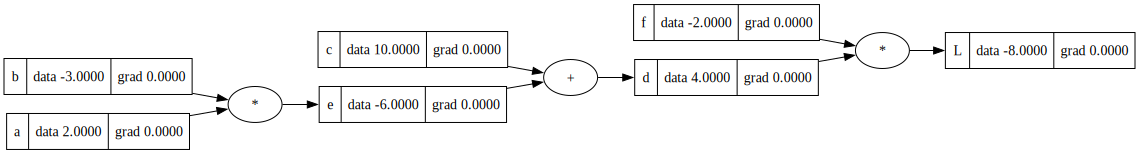

In [10]:
draw_dot(L)

In [11]:
# Mimic gradient descent, where data `data` values are adjusted to minimize some loss function.
# Gradients `grad` have been calculated via backpropogation, which computes how much each Value 
# influentces the final result
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# Recompute the Forward Pass
# After updating the variables using the gradients, assess how those changes affect the output L
# The new forward pass sets the stage for another round of backprogation, allowing the gradients to be 
# recomputed based on the updated values.
# Gradient Computation is also called backward pass
# Output Recomputation is called Forward pass, which refers to the process where the input data 
# is passed through the network layer by layer. applying weights, biases, and activation functions, 
# to compute the network's output (predicion.
e = a * b
d = e + c
L = d * f

print(L.data)

-8.0


In [12]:
d.grad = -2.0

dd / dc = 1.0
dd / de = 1.0

we know that
d = c + e

Derivative definition:
(f(x + h) - f(x))/h

((c + h + e) - (c + e))/h
(c + h + e -c - e)/h
h/h 
1

WE KNOW:
dL / dd
dd / dc

WANT: 
dL / dc = (dL / dd) * (dd / dc)  --> chain rule

KNOW: 
dL / de = -2.0

e = a * b

de / da = b

dL / da = (dL / de) * (de / da) --> chain rule
dl / db = (dL / de) * (de / db)






In [13]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()
    

-1.9999999999953388


In [14]:
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()
    

-1.9999999999953388


In [15]:
f.grad = 4.0

# Verify derivative of f 
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    f.data += h
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()

3.9999999999995595


In [16]:
c.grad = -2.0

# Veriify derivative of c
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()

-1.9999999999953388


In [17]:
e.grad = -2.0

# Verify derivative of e
def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    e.data += h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()

-1.9999999999953388


In [18]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

def lol():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
    L2 = L.data

    print((L2 - L1)/h)

lol()

-4.000000000008441


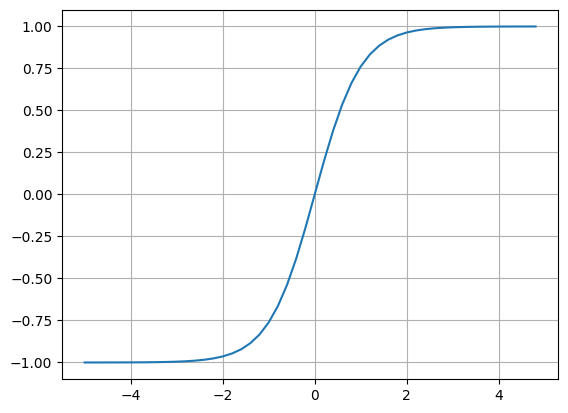

In [19]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [20]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735770195432, label='b')

# Compute the initial value for the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label  = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

# Pass the value through the activate function tanh
o = n.tanh()
o.label = 'o'


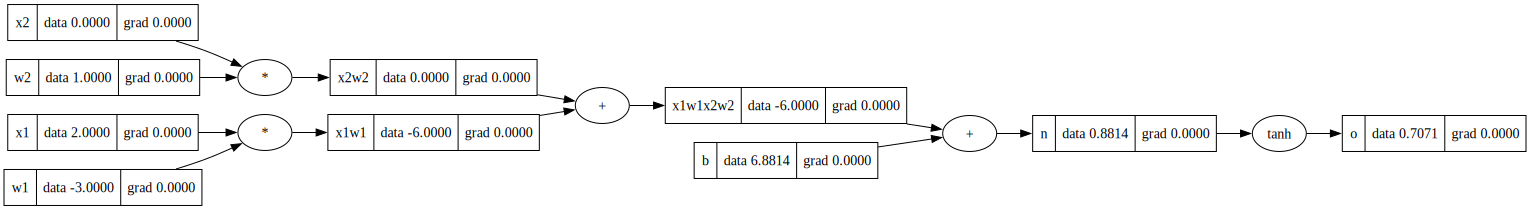

In [21]:
draw_dot(o)

# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2

In [22]:
# Perform backpropagation
o.grad = 1

In [23]:
n.grad = 1 - o.data**2

In [24]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [25]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [26]:
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [27]:
# Add _backward() to the class to self perform backpropagation

class Value: 
    """
    Represents a value in a computational graph, typically used for building an autograd system.
    It stores the value of a computation and tracks its relationship with other values for gradient computation (backpropagation).
    """
    def __init__(self, data, _children=(), _op='', label=''):
        # A constructor for the class to create object 
        # It's called automatically when creating a new instance of the class
        # self is similar to this in Java, but it has to be specified in Python and must come as the first parameter
        # :_children=(): an optional parameter with a default value of an empty tuple ().
        # _ before _children and _op is a convention in Python indicating that these attributes are intended to be private to the class.
        # It suggests that they are internal details, not meant to be accessed directly outside the class, though it does not prevent access.
        self.data = data
        self.grad = 0.0              # gradient = 0 meaning it does not affect the loss function value as default
                                     # it represent the derivatives of L (loss function) in regards to each node/weight of the model in backpropagation
        self._backward = lambda: None
        self._prev = set(_children)  # keep track of the "previous" Value objects involved in the operation
                                     # It's a set of other Value objects that were used in the current opeartion, enabling backtracking during gradient computation
        self._op = _op               # Stores the operation performed to create the current Value object.
                                     # This helps in determining how to compute derivatives during backpropagation or other opeartions.
        self.label = label
        
    def __repr__(self):
        # The representation method defining how the object is represented as a string when printed or logged
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad    # += to accumulate the gradients
            other.grad += 1.0 * out.grad
        out._backward = _backward # the _backward function as a property (attribute) of the Value object out
                                  # Later, when the _backward() method is called, the _backward function of each node
                                  # node is invoked to propagate gradients to its input recursively.
        
        return out

    def __mul__(self, other):
        # check if `other` is a Value object, if not wrap it in a Value object before doing op
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __rmul__(self, other): 
        # Handles the case when 'other * self' is called.
        # This function is called when the multiplication operation is attempted and 'self' 
        # is on the righ side of the '*' operator, e.g 3 * Value(2)

        # Python first tries to call the left operand's __mul__ method.
        # If the left operand doesn't have __mul__ or it doesn't know how to handle
        # multipliction with 'self', Python calls the right operand's __rmul__ method.
        
        # Step 1: Python tries 3.__mul__(Value(2.0)), which fails because int doesn’t know how to handle Value.
        # Step 2: Python falls back to Value(2.0).__rmul__(3).
        # Step 3: Inside __rmul__, self is Value(2.0), and other is 3
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        # Instead of implementing division logic directly, this method leverages the __mul__ method
        # by multiplying `self` with the reciprocal of `other` (computed as other**(-1).
        # This ensures consisten behavior across multiplication and division, 
        # while keeping the implemetation simple and centralized.
        return self * other**(-1)

    def __neg__(self):
        return self * (-1)

    def __sub__(self, other):
        return self + (-other)
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'  # Internallly, Python interprets this operation as a.__add__(b) which is called operator overloading using the magic method/dunder
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'   # (;) is used to separate multiple statements on the same line
L
# a.__mul__(b).__add__(c)

Value(data=-8.0)

In [28]:
a = Value(2.0, 'a')
b = Value(4.0)
a + 1
2 * a
a.exp()

a/b
a - b

Value(data=-2.0)

In [29]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735770195432, label='b')

# Compute the initial value for the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label  = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

# Pass the value through the activate function tanh
o = n.tanh()
o.label = 'o'


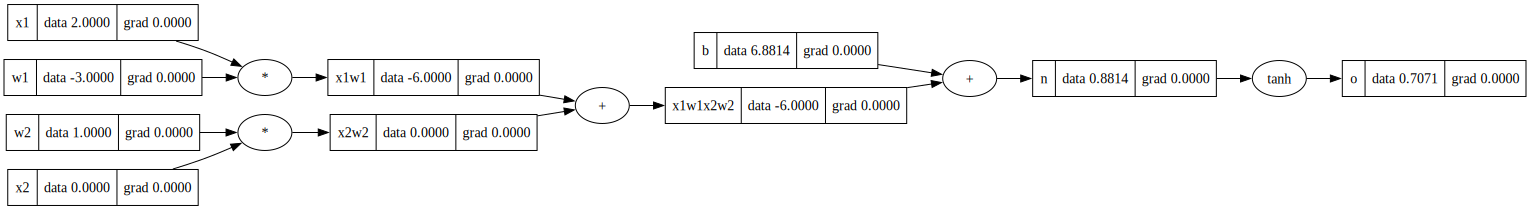

In [30]:
draw_dot(o)

In [31]:
# because grad is default to 0 in the object, we need to initialize it before calling _backward()
o.grad = 1.0

o._backward()

n._backward()

b._backward() # b is a leaf node so it won't do propagation 

x1w1x2w2._backward()

x1w1._backward()

x2w2._backward()

In [32]:
# This code implements a topological sort that is used to automate backpropagation within the Value class
# instead of calling _backward() on each parent node
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373577019543),
 Value(data=0.8813735770195432),
 Value(data=0.7071067761865476)]

In [33]:
o.backward()

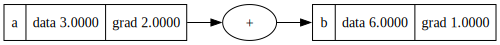

In [34]:
# This code illustrate some bugs with the current code implementation so far in the backpropagation
# before accumulating the gradients with += in _backward() definition in the class Value:

a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

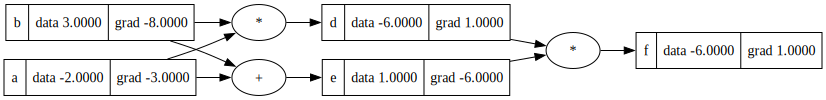

In [35]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b;   d.label = 'd'
e = a + b;   e.label = 'e'
f = d * e;   f.label = 'f'

f.backward()

draw_dot(f)

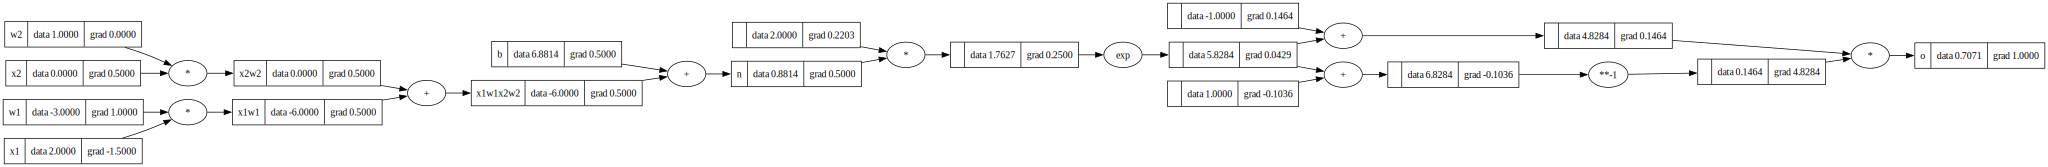

In [36]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weight w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias of the neuron
b = Value(6.8813735770195432, label='b')

# Compute the initial value for the neuron
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label  = 'x2w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b
n.label = 'n'

#---------
e = (2*n).exp() 
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)
# Pass the value through the activate function tanh


In [37]:
import torch

In [38]:
# Demonstrate the same logic above with Pytorch tensors
x1 = torch.tensor([2.0]).double()                       ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()                       ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()                      ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()                       ; w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double()         ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [39]:
o.item()

0.7071066904050358

In [40]:
import random

In [41]:
class Neuron:

    def __init__(self, nin):
        # `self.w` is a list of `Value` objects with the length of `nin`, representing the weights of the neuron.
        # Each weight is initialized to a random value between -1 and 1.
        # random.uniform() provides a uniform distribution, meaning every number in the range has an equal probability of being selected.
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]  # This is called a list comprehension in Python

        # `self.b` is a single `Value` object representing the bias of the neuron.
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # This method is invoked when an instance of the class is called like a function (e.g, `n(x)`)
        # print(list(zip(self.w, x))) # [(Value(data=0.39262953523948485), 2.0), (Value(data=-0.5394147081327125), 3.0)]
        # 1. Pair up each weight with its corresponding input value using `zip(self.w, x)`
        # For example, self.w = [w1, w2] and x = [x1, x2] --> zip(self.w, x) = [(w1, x1), (w2, x2)]
        wx_pair = zip(self.w, x)

        # 2. Multiply each weight and its corresponding input using a generator expression
        # This creates a sequence of products: [w1*x1, w2*x2, ...]
        weighted_inputs = (wi * xi for wi, xi in wx_pair)

        # 3. Sum up all the weighted inputs and add the bias `self.b`
        # Thge `sum()` function calculates the sum of the weighted inputs,
        # and the bias term `self.b` is added as the starting value.
        # The result `act` is the total activation of the neuron before applying an activation function.
        act = sum(weighted_inputs, self.b)
        out = act.tanh()
        
        return out

    def parameters(self):
        # Return all the parameters of a single neuron, which are `self.w` and `self.b` as lists
        return self.w + [self.b]


class Layer:

    def __init__(self, nin, nout):
        # Create a list of neurons. The layer contains `nout` neurons. Each neuron takes `nin` inputs.
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # Process the input `x` through each neuron in the layer.
        # For every neuron in the layer: 
        #  - pass the input `x` to the neuron's __call__ method.
        #  - Collect the output from each neuron in a list
        outs = [n(x) for n in self.neurons]
        
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []

        # Iterate over all neurons in the layer
        # Call the parameters method of each Neuron to gets its weights and bias.
        # Combine all the paraneter into a single list using extend
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        
        return params

        # List comprehension logic
        # return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:

    def __init__(self, nin, nouts):
        # Define the sizes of all layers in the MLP.
        # - Combine the input size `nin` with the list of output sizes `nouts`.
        # - Example: If nin=3 and nouts=[4, 5, 2], then sz = [3, 4, 5, 2]
        sz = [nin] + nouts

        # Create the layers of the MLP.
        #  - Iterate throught `sz` list to define each layer.
        #  - Each layer connects sz[i] inputs to sz[i+1] outputs.
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        # Pass the input `x` through each layer in the MLP sequentially.
        for layer in self.layers:
            # Update `x` by feeding it through the current lyare
            x = layer(x)

        return x

    def parameters(self):
        # Iterate over all layers in the MLP, and call the parameter method of each Layer to retrive its parameters
        return [p for layer in self.layers for p in layer.parameters()]
        

In [42]:
x = [2.0, 3.0]
n = Neuron(2)  # initializes the Neuron object with two inputs.
n(x)

l = Layer(nin=2, nout=3)
l(x) 

# [Value(data=0.6042432607116167),
 # Value(data=-0.48336993387561894),
 # Value(data=0.9787226739029214)]

layer = Layer(nin=3, nout=2)  # Create a layer with 2 neurons, each accepting 3 inputs.
input_data = [1.0, -2.0, 3.5]  # Input vector with 3 elements.
output = layer(input_data)  # Call the layer with input data.
# print(output)  # Outputs a list of results from the two neurons, e.g., [1.23, 4.56].
# Returns: [Value(data=-0.946122217338325), Value(data=0.9992526412106517)]

x1 = [2.0, 3,0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x1)

Value(data=0.7735316775450679)

In [43]:
mlp.parameters()

[Value(data=0.00868049959267192),
 Value(data=0.09307241034864067),
 Value(data=-0.03227556453205804),
 Value(data=0.816985933833229),
 Value(data=0.6186028978390661),
 Value(data=-0.6769858126212822),
 Value(data=0.09459064914358528),
 Value(data=0.953042713338307),
 Value(data=0.12395769904503506),
 Value(data=0.45466579265524976),
 Value(data=-0.40667199636492946),
 Value(data=-0.7589940850352577),
 Value(data=-0.4575887551363014),
 Value(data=0.23682746955988665),
 Value(data=-0.7778758444241693),
 Value(data=-0.8314429082704324),
 Value(data=0.576997545515489),
 Value(data=0.11438122029773456),
 Value(data=0.3706232166280492),
 Value(data=-0.016376104729255214),
 Value(data=0.23996096641046738),
 Value(data=-0.4697844601485428),
 Value(data=0.1147312392223363),
 Value(data=0.7784386810425079),
 Value(data=0.8722467156326905),
 Value(data=-0.050058429772282365),
 Value(data=0.9381512536575194),
 Value(data=0.10416887632457428),
 Value(data=-0.9038907968104131),
 Value(data=-0.41675

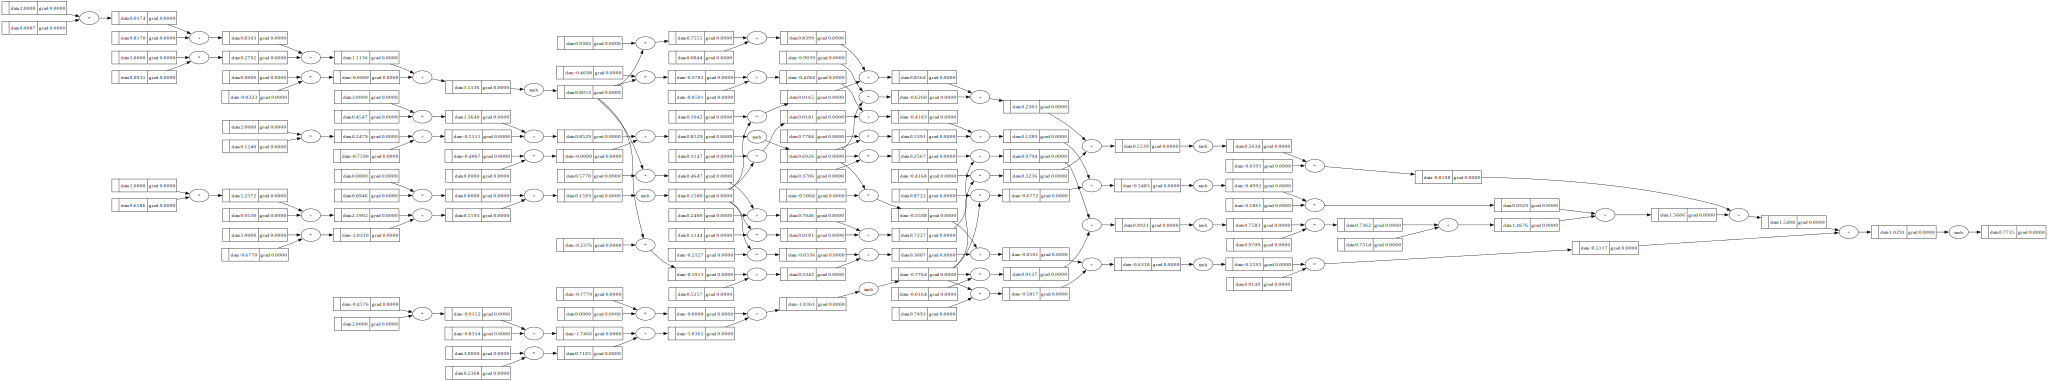

In [44]:
draw_dot(mlp(x1))

In [45]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.8357496174304514),
 Value(data=0.8021885848280086),
 Value(data=0.9073653295079072),
 Value(data=0.8714946524789849)]

In [46]:
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred), Value(0))
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred), start=Value(0))
loss = Value(0)  # Initialize with Value(0)
for ygt, yout in zip(ys, ypred):  # ygt means "y ground truth", the true value
    loss += (yout - ygt) ** 2  # Accumulate the squared differences
    
    # The ** 2 ensures that:
    #  Errors are always non-negative.
    #  Larger errors are penalized more heavily.
    #  The loss function is smooth and differentiable for optimization.
loss

Value(data=6.929418008008927)

In [47]:
# 1
loss.backward()

In [48]:
# 2
for p in mlp.parameters():
    p.data += -0.1 * p.grad

In [49]:
# 3 (repeat until loss becomes desirable)
# Reiterate through the process with updated loss
ypred = [mlp(x) for x in xs]

loss = Value(0)  # Initialize with Value(0)
for ygt, yout in zip(ys, ypred):  # ygt means "y ground truth", the true value
    loss += (yout - ygt) ** 2  # Accumulate the squared differences
    
    # The ** 2 ensures that:
    #  Errors are always non-negative.
    #  Larger errors are penalized more heavily.
    #  The loss function is smooth and differentiable for optimization.
loss

Value(data=3.671995625673091)

In [50]:
ypred

[Value(data=0.5520423618950664),
 Value(data=-0.21137185756422947),
 Value(data=0.5849640450682168),
 Value(data=0.41923825114265467)]

In [51]:
mlp.parameters()

[Value(data=-0.05426192838302628),
 Value(data=0.10951202745095943),
 Value(data=-0.038006738214857394),
 Value(data=0.7920820096468294),
 Value(data=0.619066320337699),
 Value(data=-0.6742622454236467),
 Value(data=0.08870604126511965),
 Value(data=0.9589925227909682),
 Value(data=0.15645263939521392),
 Value(data=0.46465623121847494),
 Value(data=-0.42296274637840936),
 Value(data=-0.7302228187391162),
 Value(data=-0.46663862037035736),
 Value(data=0.21909597899541608),
 Value(data=-0.7507995471237466),
 Value(data=-0.8602013028190381),
 Value(data=0.4901725343836339),
 Value(data=-0.003385798488328151),
 Value(data=0.4489626148219195),
 Value(data=0.08601762422625314),
 Value(data=0.10616137307517803),
 Value(data=-0.46149383624822815),
 Value(data=0.12226288131519791),
 Value(data=0.7762412810102285),
 Value(data=0.8694904658755206),
 Value(data=-0.0381761805662806),
 Value(data=0.9392596306393909),
 Value(data=0.10525445527490443),
 Value(data=-0.9043079397907348),
 Value(data=-0.

In [52]:
# Optimization
for k in range(200):

    # forward pass
    ypred = [mlp(x) for x in xs]
    
    loss = Value(0)  # Initialize with Value(0)
    for ygt, yout in zip(ys, ypred):  # ygt means "y ground truth", the true value
        loss += (yout - ygt) ** 2

    # backward pass
    # Reset `p.grad` to ensure that gradients calculated during backpropagation are fresh for each iteration.
    # This avoids uintended accumulation and ensures the optimizer updates the parameters correctly.
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -.1 * p.grad

    print(k, loss.data)
    print('p.grad:', p.grad)

0 3.671995625673091
p.grad: 2.0117626179411117
1 3.5421294041041116
p.grad: -2.8441363077438533
2 3.9996032794433583
p.grad: 1.2027414433564587
3 3.628693927154777
p.grad: 0.886758913194135
4 3.0876279091502057
p.grad: 1.4120932303211122
5 2.2505811764502486
p.grad: -0.47817874956163076
6 2.2037554205558254
p.grad: 1.079638042532637
7 2.3171157469452175
p.grad: -1.4932334850724982
8 2.7136952683296696
p.grad: 1.9399370167022523
9 2.2532067156873157
p.grad: -1.5985462187416575
10 2.5650341889389865
p.grad: 2.0582311908728563
11 2.282490473776506
p.grad: -1.7354659493370774
12 2.483963237436453
p.grad: 2.086902986687505
13 2.2128585924898836
p.grad: -1.7057398503759984
14 2.338182170170356
p.grad: 2.0446107122510147
15 2.1964493259092364
p.grad: -1.7469915361317352
16 2.263610202941101
p.grad: 2.062027913810423
17 2.1855900303229614
p.grad: -1.7809336097496038
18 2.1956291564857735
p.grad: 2.065318506723232
19 2.1728044652795284
p.grad: -1.8064956222579454
20 2.136330813340734
p.grad: 2.

In [53]:
ypred

[Value(data=0.9867906126480005),
 Value(data=-0.9813184868848537),
 Value(data=-0.9649728666087795),
 Value(data=0.961868025383815)]